In [1]:
import csv
import numpy as np
import os
import pandas as pd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import ticker
from scipy.stats import spearmanr
from torch.utils.tensorboard import SummaryWriter

from src.utils import Plotting 
from src.utils import Dataloader
from src.utils import EarlyStopping
import datetime

import seaborn as sns

from sklearn.metrics import mean_absolute_error

In [2]:
seed=999
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
fname="/gpfs/work/sharmas/mc-snow-data/Timeseries_data.csv"

In [5]:
df=pd.read_csv(fname)

In [6]:
df.head()

,time,Lc,Nc,Zc,Lr,Nr,Zr,auto_num,auto_mass,accr_num,accr_mass,self_cloud,self_rain,nsp,lwc0,rm,nu_gam,mu_gam
0,20.0,0.000998,70616000.0,1.982130e-14,6.940890e-15,0.000026,1.825170e-24,0.000001,3.470440e-16,0.000000,0.000000e+00,5975.81,0.0,27860.0,0.001,0.000015,1.5,1.0
1,40.0,0.000998,70480600.0,1.991330e-14,1.664520e-10,0.579694,4.779850e-20,0.028983,8.227570e-12,0.028652,9.469380e-14,6770.35,0.0,27860.0,0.001,0.000015,1.5,1.0
2,60.0,0.000998,70354000.0,2.000490e-14,1.984290e-10,0.598563,6.586050e-20,0.000943,2.523660e-13,0.086980,1.346460e-12,6327.91,0.0,27860.0,0.001,0.000015,1.5,1.0
3,80.0,0.000998,70238000.0,2.009590e-14,2.407490e-10,0.663857,8.806710e-20,0.003265,8.900880e-13,0.030139,1.225930e-12,5801.94,0.0,27860.0,0.001,0.000015,1.5,1.0
4,100.0,0.000998,70093100.0,2.021030e-14,2.914650e-10,0.749375,1.155360e-19,0.004276,1.142440e-12,0.097133,1.393350e-12,7244.83,0.0,27860.0,0.001,0.000015,1.5,1.0


In [7]:
epsilon=1e-15

In [8]:
df["Xc"]=(df['Lc']/df['Nc'])
df["tau"]=(df['Lr']/df['lwc0'])

In [9]:
kcc = 9.44e9
kcr = 5.78
xstar = 2.6e-10 
rhow = 1e3

In [12]:
xc0 = np.pi*rhow/6. * (df['rm']*2)**3 

In [13]:
auto_fac = kcc/(20*xstar) * (df['nu_gam']+2.0)*(df['nu_gam']+4.0)/(df['nu_gam']+1.0)**2 * df['lwc0']**2 * (xc0**2)
auto_norm=np.log((df['auto_mass']/auto_fac).to_numpy())

<ipython-input-13-4befec61b557>:2: RuntimeWarning: divide by zero encountered in log
  auto_norm=np.log((df['auto_mass']/auto_fac).to_numpy())


In [10]:
accr_norm=np.log((df['accr_mass']/auto_fac).to_numpy())

In [14]:
df.head()

,time,Lc,Nc,Zc,Lr,Nr,Zr,auto_num,auto_mass,accr_num,accr_mass,self_cloud,self_rain,nsp,lwc0,rm,nu_gam,mu_gam,Xc,tau
0,20.0,0.000998,70616000.0,1.982130e-14,6.940890e-15,0.000026,1.825170e-24,0.000001,3.470440e-16,0.000000,0.000000e+00,5975.81,0.0,27860.0,0.001,0.000015,1.5,1.0,1.413810e-11,6.940890e-12
1,40.0,0.000998,70480600.0,1.991330e-14,1.664520e-10,0.579694,4.779850e-20,0.028983,8.227570e-12,0.028652,9.469380e-14,6770.35,0.0,27860.0,0.001,0.000015,1.5,1.0,1.416526e-11,1.664520e-07
2,60.0,0.000998,70354000.0,2.000490e-14,1.984290e-10,0.598563,6.586050e-20,0.000943,2.523660e-13,0.086980,1.346460e-12,6327.91,0.0,27860.0,0.001,0.000015,1.5,1.0,1.419075e-11,1.984290e-07
3,80.0,0.000998,70238000.0,2.009590e-14,2.407490e-10,0.663857,8.806710e-20,0.003265,8.900880e-13,0.030139,1.225930e-12,5801.94,0.0,27860.0,0.001,0.000015,1.5,1.0,1.421419e-11,2.407490e-07
4,100.0,0.000998,70093100.0,2.021030e-14,2.914650e-10,0.749375,1.155360e-19,0.004276,1.142440e-12,0.097133,1.393350e-12,7244.83,0.0,27860.0,0.001,0.000015,1.5,1.0,1.424357e-11,2.914650e-07


In [11]:
d=df[['Lc','Xc','Lr','nu_gam','tau','auto_mass','accr_mass','self_cloud','self_rain','Lc','Nc','Lr','Nr','rm','lwc0','nu_gam']].to_numpy()

#d=np.log(d+epsilon)

In [12]:
input_num=d.shape[-1]-11

In [13]:
d.shape

(487881, 16)

In [14]:
time=df['time']
timestep,dataset=Dataloader.create_dataset_PR_nets(d, time)

In [15]:
means, sds, dataset=Dataloader.norm_data(dataset,1)

In [16]:
train_dataloader,val_dataloader,test_dataloader,train_dataset,val_dataset, test_dataset=Dataloader.dataset_transform(dataset)

In [17]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torch.optim as optim

In [29]:
depth=input_num
class Network(nn.Module):

    def __init__(self,act):
        
        super().__init__()
       
        self.fc1 = nn.Linear(depth, 20)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_out')
        self.b1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(20, 20)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_out')
        self.b2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(20,20)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_out')
        self.b3 = nn.BatchNorm1d(20)
        self.fc4 = nn.Linear(20,4)
        self.activation = act
        
    def forward(self,x,verbose=False):
        x=self.activation((self.fc1(x)))
        if verbose:
            print(x.shape)
        x=self.activation((self.fc2(x)))
        if verbose:
            print(x.shape)
        x=self.activation((self.fc3(x)))
        if verbose:
            print(x.shape)
  
            
        x=(self.fc4(x))
        if verbose:
            print(x.shape)
        
        return x

In [105]:
model = Network(nn.ReLU())
model.to(device)

Network(
  (fc1): Linear(in_features=5, out_features=20, bias=True)
  (b1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (b2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (b3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=20, out_features=4, bias=True)
  (activation): ReLU()
)

In [106]:

LF = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [107]:
losses=[]
val_loss=[]
n_epochs=500
j=0
patience=10
log_dir = "runs/PR_nets/4L_relu_L1_earlystopping/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

early_stopping = EarlyStopping.EarlyStopping(patience=patience, verbose=True)

for epoch in range(n_epochs):  

    print(f'epoch {epoch}')
    
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        inputs=data[:,1:input_num+1].to(device)
        outputs=data[:,input_num+1:input_num+5].to(device)
        optimizer.zero_grad()
        
        preds = model(inputs)
        loss = LF(preds, outputs)
        
        loss.backward()
        
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)
        
        writer.add_scalar("Training Loss", loss.item() , j)
    print(f'Loss: {running_loss/ len(train_dataset)}')
    losses.append(running_loss / len(train_dataset))
    writer.add_scalar("Loss/train", losses[epoch], epoch)
    
    
    with torch.no_grad():
        running_loss = 0.0
        for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            inputs=data[:,1:input_num+1].to(device)
            outputs=data[:,input_num+1:input_num+5].to(device)
            model.eval()

            yhat = model(inputs)
            loss_v = LF(yhat, outputs)
            running_loss += loss_v.item()* inputs.size(0)
            
    print(f'Loss: {(running_loss/len(val_dataset))}')
    val_loss.append(running_loss / len(val_dataset))
    writer.add_scalars("Training/Validation", {'Training':losses[epoch],'Validation':val_loss[epoch]}, epoch)
    early_stopping(val_loss[epoch], model)
    
    if early_stopping.early_stop:
            print("Early stopping")
            break
            
model.load_state_dict(torch.load('checkpoint.pt'))
   
    
writer.close()
  

epoch 0


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.23580968737670688


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.1689337028005425
Validation loss decreased (inf --> 0.168934).  Saving model ...
epoch 1


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.15639881497044741


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.14195521938920755
Validation loss decreased (0.168934 --> 0.141955).  Saving model ...
epoch 2


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.13251300244321154


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.11938958200814412
Validation loss decreased (0.141955 --> 0.119390).  Saving model ...
epoch 3


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.11382480101972614


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.10581274571439357
Validation loss decreased (0.119390 --> 0.105813).  Saving model ...
epoch 4


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.10388559848247693


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.09928466891778047
Validation loss decreased (0.105813 --> 0.099285).  Saving model ...
epoch 5


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.09861122534819364


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.09524225110675519
Validation loss decreased (0.099285 --> 0.095242).  Saving model ...
epoch 6


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.09488978622139901


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.09202351683846056
Validation loss decreased (0.095242 --> 0.092024).  Saving model ...
epoch 7


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0917980015197078


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08927191970316913
Validation loss decreased (0.092024 --> 0.089272).  Saving model ...
epoch 8


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08910861660956583


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08672938124662186
Validation loss decreased (0.089272 --> 0.086729).  Saving model ...
epoch 9


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08675551454033766


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08464104749689927
Validation loss decreased (0.086729 --> 0.084641).  Saving model ...
epoch 10


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08470379354188823


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08273937538056084
Validation loss decreased (0.084641 --> 0.082739).  Saving model ...
epoch 11


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08284748979908335


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.08099965201738263
Validation loss decreased (0.082739 --> 0.081000).  Saving model ...
epoch 12


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.08119077995121714


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07946286265344807
Validation loss decreased (0.081000 --> 0.079463).  Saving model ...
epoch 13


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07972876336004975


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07813195926037707
Validation loss decreased (0.079463 --> 0.078132).  Saving model ...
epoch 14


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07836760996945433


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07671465627733697
Validation loss decreased (0.078132 --> 0.076715).  Saving model ...
epoch 15


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07706762355986796


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07552468016817145
Validation loss decreased (0.076715 --> 0.075525).  Saving model ...
epoch 16


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07583617543194757


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07423240959056439
Validation loss decreased (0.075525 --> 0.074232).  Saving model ...
epoch 17


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07446915531176163


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07274015107174653
Validation loss decreased (0.074232 --> 0.072740).  Saving model ...
epoch 18


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07300186098374133


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.07138637118640738
Validation loss decreased (0.072740 --> 0.071386).  Saving model ...
epoch 19


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07177817421896261


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0702210505249659
Validation loss decreased (0.071386 --> 0.070221).  Saving model ...
epoch 20


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.07074371935671525


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06924145456363792
Validation loss decreased (0.070221 --> 0.069241).  Saving model ...
epoch 21


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0698077317369996


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06834176888347497
Validation loss decreased (0.069241 --> 0.068342).  Saving model ...
epoch 22


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06896776632901788


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06757205929181778
Validation loss decreased (0.068342 --> 0.067572).  Saving model ...
epoch 23


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06817255031202879


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06674120216590636
Validation loss decreased (0.067572 --> 0.066741).  Saving model ...
epoch 24


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06743522061586288


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0660336330107407
Validation loss decreased (0.066741 --> 0.066034).  Saving model ...
epoch 25


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06674073494798724


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.065374975327084
Validation loss decreased (0.066034 --> 0.065375).  Saving model ...
epoch 26


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0660578454137819


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0647396616830543
Validation loss decreased (0.065375 --> 0.064740).  Saving model ...
epoch 27


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0654051334922448


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06406801094429829
Validation loss decreased (0.064740 --> 0.064068).  Saving model ...
epoch 28


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06478729854497178


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06345440883820966
Validation loss decreased (0.064068 --> 0.063454).  Saving model ...
epoch 29


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06421717992996218


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06291045002553479
Validation loss decreased (0.063454 --> 0.062910).  Saving model ...
epoch 30


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06366258668994051


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.062441544715314365
Validation loss decreased (0.062910 --> 0.062442).  Saving model ...
epoch 31


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06314400349486705


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.061921941302235876
Validation loss decreased (0.062442 --> 0.061922).  Saving model ...
epoch 32


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06262197878910415


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.061507819285055894
Validation loss decreased (0.061922 --> 0.061508).  Saving model ...
epoch 33


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06213430808059533


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06092764038106541
Validation loss decreased (0.061508 --> 0.060928).  Saving model ...
epoch 34


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06164015226465054


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.06041646235669133
Validation loss decreased (0.060928 --> 0.060416).  Saving model ...
epoch 35


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06113672276601766


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05998199219249686
Validation loss decreased (0.060416 --> 0.059982).  Saving model ...
epoch 36


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06059679324359917


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05940206155832925
Validation loss decreased (0.059982 --> 0.059402).  Saving model ...
epoch 37


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.06008885716677966


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05886834925927723
Validation loss decreased (0.059402 --> 0.058868).  Saving model ...
epoch 38


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05958893381010393


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05837543800898834
Validation loss decreased (0.058868 --> 0.058375).  Saving model ...
epoch 39


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05910880851023594


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0578972660252426
Validation loss decreased (0.058375 --> 0.057897).  Saving model ...
epoch 40


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05863793002156794


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05746517165089246
Validation loss decreased (0.057897 --> 0.057465).  Saving model ...
epoch 41


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.058182740264909216


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05702092581601018
Validation loss decreased (0.057465 --> 0.057021).  Saving model ...
epoch 42


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.057755882831120944


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05659536266438167
Validation loss decreased (0.057021 --> 0.056595).  Saving model ...
epoch 43


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.057334870624800784


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.056146548307301224
Validation loss decreased (0.056595 --> 0.056147).  Saving model ...
epoch 44


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05691458528204979


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05587467478254459
Validation loss decreased (0.056147 --> 0.055875).  Saving model ...
epoch 45


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05654024208672551


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.055462153785671965
Validation loss decreased (0.055875 --> 0.055462).  Saving model ...
epoch 46


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.056162299766302784


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.055085695365164805
Validation loss decreased (0.055462 --> 0.055086).  Saving model ...
epoch 47


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.055810693633263686


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.054796907695557374
Validation loss decreased (0.055086 --> 0.054797).  Saving model ...
epoch 48


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05546233452025169


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05443257721419755
Validation loss decreased (0.054797 --> 0.054433).  Saving model ...
epoch 49


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.055115775802812454


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.054084322565504786
Validation loss decreased (0.054433 --> 0.054084).  Saving model ...
epoch 50


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05475661827231945


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.053780362831504225
Validation loss decreased (0.054084 --> 0.053780).  Saving model ...
epoch 51


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05444798989787008


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0534134739908184
Validation loss decreased (0.053780 --> 0.053413).  Saving model ...
epoch 52


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05412249096570785


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05303682666934029
Validation loss decreased (0.053413 --> 0.053037).  Saving model ...
epoch 53


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05381614567179932


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05279718732012903
Validation loss decreased (0.053037 --> 0.052797).  Saving model ...
epoch 54


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.053494817282356


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.052411719147460435
Validation loss decreased (0.052797 --> 0.052412).  Saving model ...
epoch 55


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05316505973328124


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05216106652916109
Validation loss decreased (0.052412 --> 0.052161).  Saving model ...
epoch 56


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05286349851835922


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05195683199573736
Validation loss decreased (0.052161 --> 0.051957).  Saving model ...
epoch 57


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05257381116753691


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05156815240173563
Validation loss decreased (0.051957 --> 0.051568).  Saving model ...
epoch 58


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05231798204998128


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05126826242485376
Validation loss decreased (0.051568 --> 0.051268).  Saving model ...
epoch 59


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.052048926239125125


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05105327722122875
Validation loss decreased (0.051268 --> 0.051053).  Saving model ...
epoch 60


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05178020464889404


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.050864055090255704
Validation loss decreased (0.051053 --> 0.050864).  Saving model ...
epoch 61


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05154398930051163


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05062645669268759
Validation loss decreased (0.050864 --> 0.050626).  Saving model ...
epoch 62


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.051322913154784


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05035721604904219
Validation loss decreased (0.050626 --> 0.050357).  Saving model ...
epoch 63


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.051051205329395825


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.05013395613714724
Validation loss decreased (0.050357 --> 0.050134).  Saving model ...
epoch 64


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.050838216322520495


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04990153090650181
Validation loss decreased (0.050134 --> 0.049902).  Saving model ...
epoch 65


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05059561623009505


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049772041848152156
Validation loss decreased (0.049902 --> 0.049772).  Saving model ...
epoch 66


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.05036210531944294


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.049541945558995895
Validation loss decreased (0.049772 --> 0.049542).  Saving model ...
epoch 67


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.050150379805944


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04930265760936345
Validation loss decreased (0.049542 --> 0.049303).  Saving model ...
epoch 68


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04992828792287282


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04908010363887039
Validation loss decreased (0.049303 --> 0.049080).  Saving model ...
epoch 69


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04972707783647409


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.048998947474892716
Validation loss decreased (0.049080 --> 0.048999).  Saving model ...
epoch 70


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04952247275228704


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0489931336048175
Validation loss decreased (0.048999 --> 0.048993).  Saving model ...
epoch 71


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04933387730087774


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0486377602953178
Validation loss decreased (0.048993 --> 0.048638).  Saving model ...
epoch 72


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04914001033571876


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04845961468852674
Validation loss decreased (0.048638 --> 0.048460).  Saving model ...
epoch 73


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04895775933920809


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04831445023428323
Validation loss decreased (0.048460 --> 0.048314).  Saving model ...
epoch 74


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04880464475920439


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04816797317751701
Validation loss decreased (0.048314 --> 0.048168).  Saving model ...
epoch 75


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04864201350373891


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04806197883400105
Validation loss decreased (0.048168 --> 0.048062).  Saving model ...
epoch 76


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.048488010302931615


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04784737673149222
Validation loss decreased (0.048062 --> 0.047847).  Saving model ...
epoch 77


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04833920634949843


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04771935989719101
Validation loss decreased (0.047847 --> 0.047719).  Saving model ...
epoch 78


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.048175573797173625


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.047657330161694295
Validation loss decreased (0.047719 --> 0.047657).  Saving model ...
epoch 79


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04803192455735017


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04744191676525713
Validation loss decreased (0.047657 --> 0.047442).  Saving model ...
epoch 80


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.047905100391343554


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0475257971370941
EarlyStopping counter: 1 out of 10
epoch 81


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.047734988426022744


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04724552376190733
Validation loss decreased (0.047442 --> 0.047246).  Saving model ...
epoch 82


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04759188982660117


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04705278450611935
Validation loss decreased (0.047246 --> 0.047053).  Saving model ...
epoch 83


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.047448157655982204


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.047109348632894864
EarlyStopping counter: 1 out of 10
epoch 84


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04731631697853517


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04697293642731527
Validation loss decreased (0.047053 --> 0.046973).  Saving model ...
epoch 85


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04720676602063862


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04678129378599935
Validation loss decreased (0.046973 --> 0.046781).  Saving model ...
epoch 86


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04708100127756313


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04657101152116927
Validation loss decreased (0.046781 --> 0.046571).  Saving model ...
epoch 87


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04695106152437458


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.046635435853936896
EarlyStopping counter: 1 out of 10
epoch 88


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046855814856116305


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04633885088358884
Validation loss decreased (0.046571 --> 0.046339).  Saving model ...
epoch 89


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04675086958531977


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.046314894945709714
Validation loss decreased (0.046339 --> 0.046315).  Saving model ...
epoch 90


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04665096087682349


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04631512373098451
EarlyStopping counter: 1 out of 10
epoch 91


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046564429849466606


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04607633987850141
Validation loss decreased (0.046315 --> 0.046076).  Saving model ...
epoch 92


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04646128982828605


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04622136115470037
EarlyStopping counter: 1 out of 10
epoch 93


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0463765078701718


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04596280220188528
Validation loss decreased (0.046076 --> 0.045963).  Saving model ...
epoch 94


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046271843289934465


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045923768811235124
Validation loss decreased (0.045963 --> 0.045924).  Saving model ...
epoch 95


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.046211791734027785


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04575823069594299
Validation loss decreased (0.045924 --> 0.045758).  Saving model ...
epoch 96


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0461079583284841


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045894746461066595
EarlyStopping counter: 1 out of 10
epoch 97


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04604510488877506


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045704070343149876
Validation loss decreased (0.045758 --> 0.045704).  Saving model ...
epoch 98


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04597007556969767


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04553720361198716
Validation loss decreased (0.045704 --> 0.045537).  Saving model ...
epoch 99


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04588282600340921


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045600564024507496
EarlyStopping counter: 1 out of 10
epoch 100


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04579608132036206


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045427745841002135
Validation loss decreased (0.045537 --> 0.045428).  Saving model ...
epoch 101


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045713356572728445


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045412468558352806
Validation loss decreased (0.045428 --> 0.045412).  Saving model ...
epoch 102


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045662502852755735


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04523723339552838
Validation loss decreased (0.045412 --> 0.045237).  Saving model ...
epoch 103


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04559786642506659


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04518139715805011
Validation loss decreased (0.045237 --> 0.045181).  Saving model ...
epoch 104


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04551730735275071


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04514670101355483
Validation loss decreased (0.045181 --> 0.045147).  Saving model ...
epoch 105


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045463305916869104


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045364699291698216
EarlyStopping counter: 1 out of 10
epoch 106


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04540162068075519


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.045029433824784304
Validation loss decreased (0.045147 --> 0.045029).  Saving model ...
epoch 107


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0453387791435717


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04510420127500234
EarlyStopping counter: 1 out of 10
epoch 108


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04526178387665968


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044924951220519246
Validation loss decreased (0.045029 --> 0.044925).  Saving model ...
epoch 109


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04521406650198867


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04490644417941361
Validation loss decreased (0.044925 --> 0.044906).  Saving model ...
epoch 110


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045163282514427694


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04492418959373345
EarlyStopping counter: 1 out of 10
epoch 111


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.045088831496974034


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04476780759508115
Validation loss decreased (0.044906 --> 0.044768).  Saving model ...
epoch 112


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04503548565712023


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044772727246468184
EarlyStopping counter: 1 out of 10
epoch 113


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04498743413925508


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044566091874611524
Validation loss decreased (0.044768 --> 0.044566).  Saving model ...
epoch 114


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04490436561456605


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04462252149335335
EarlyStopping counter: 1 out of 10
epoch 115


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04487110555574114


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04448257755260551
Validation loss decreased (0.044566 --> 0.044483).  Saving model ...
epoch 116


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04481545814570606


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044459872860679706
Validation loss decreased (0.044483 --> 0.044460).  Saving model ...
epoch 117


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04474791236594297


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04431894181590046
Validation loss decreased (0.044460 --> 0.044319).  Saving model ...
epoch 118


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04470343269803633


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04451940476812016
EarlyStopping counter: 1 out of 10
epoch 119


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04463536817493438


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04417442341525057
Validation loss decreased (0.044319 --> 0.044174).  Saving model ...
epoch 120


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04461795448610226


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044318141871001075
EarlyStopping counter: 1 out of 10
epoch 121


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04454553422426384


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04412553931985371
Validation loss decreased (0.044174 --> 0.044126).  Saving model ...
epoch 122


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04448242464599614


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.044170181547944616
EarlyStopping counter: 1 out of 10
epoch 123


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04443659033976705


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04407105071283593
Validation loss decreased (0.044126 --> 0.044071).  Saving model ...
epoch 124


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.044373269284540065


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04410081426416683
EarlyStopping counter: 1 out of 10
epoch 125


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04431515094307709


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04396937043214528
Validation loss decreased (0.044071 --> 0.043969).  Saving model ...
epoch 126


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04428722819625708


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04392257092572749
Validation loss decreased (0.043969 --> 0.043923).  Saving model ...
epoch 127


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04416069157825463


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04364138727295882
Validation loss decreased (0.043923 --> 0.043641).  Saving model ...
epoch 128


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043926991147511994


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04351958709384203
Validation loss decreased (0.043641 --> 0.043520).  Saving model ...
epoch 129


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04381068247818245


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04343601740322632
Validation loss decreased (0.043520 --> 0.043436).  Saving model ...
epoch 130


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043707170871199005


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.043272776388905795
Validation loss decreased (0.043436 --> 0.043273).  Saving model ...
epoch 131


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04362621100643343


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04320657820756284
Validation loss decreased (0.043273 --> 0.043207).  Saving model ...
epoch 132


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04353701820177557


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04315488094012308
Validation loss decreased (0.043207 --> 0.043155).  Saving model ...
epoch 133


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04345199220226587


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04302561109766099
Validation loss decreased (0.043155 --> 0.043026).  Saving model ...
epoch 134


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04337736881946787


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042988546234246375
Validation loss decreased (0.043026 --> 0.042989).  Saving model ...
epoch 135


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04331144338410069


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04304427861762452
EarlyStopping counter: 1 out of 10
epoch 136


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04325108735291548


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042821768426160096
Validation loss decreased (0.042989 --> 0.042822).  Saving model ...
epoch 137


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04319566982275256


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04291439334297666
EarlyStopping counter: 1 out of 10
epoch 138


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.043112481462237014


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042841733111341214
EarlyStopping counter: 2 out of 10
epoch 139


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04306323415968602


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042608067113295824
Validation loss decreased (0.042822 --> 0.042608).  Saving model ...
epoch 140


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042990871565079546


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04253944871554962
Validation loss decreased (0.042608 --> 0.042539).  Saving model ...
epoch 141


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042970282960817036


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042502492391267924
Validation loss decreased (0.042539 --> 0.042502).  Saving model ...
epoch 142


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04288557392539169


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04270821114251282
EarlyStopping counter: 1 out of 10
epoch 143


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04284176063729725


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04244486624849062
Validation loss decreased (0.042502 --> 0.042445).  Saving model ...
epoch 144


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042790316262164826


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042460211671648644
EarlyStopping counter: 1 out of 10
epoch 145


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042747376502527454


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0423485027133586
Validation loss decreased (0.042445 --> 0.042349).  Saving model ...
epoch 146


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042695474965458065


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04228506291469732
Validation loss decreased (0.042349 --> 0.042285).  Saving model ...
epoch 147


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04265344876507663


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04237288286632167
EarlyStopping counter: 1 out of 10
epoch 148


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042600609533509116


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042307491625986585
EarlyStopping counter: 2 out of 10
epoch 149


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04255708410002308


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042224864303442314
Validation loss decreased (0.042285 --> 0.042225).  Saving model ...
epoch 150


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04251427063138631


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042167440989270076
Validation loss decreased (0.042225 --> 0.042167).  Saving model ...
epoch 151


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042477584170197834


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04217059784783691
EarlyStopping counter: 1 out of 10
epoch 152


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04244092443441443


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04211497986894499
Validation loss decreased (0.042167 --> 0.042115).  Saving model ...
epoch 153


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0423909634667397


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.042075048509977564
Validation loss decreased (0.042115 --> 0.042075).  Saving model ...
epoch 154


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04235138519487253


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04190446602690679
Validation loss decreased (0.042075 --> 0.041904).  Saving model ...
epoch 155


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042307416169551026


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04200265710837924
EarlyStopping counter: 1 out of 10
epoch 156


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04227137505559443


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041912916518253136
EarlyStopping counter: 2 out of 10
epoch 157


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04222047746863866


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041972776304676704
EarlyStopping counter: 3 out of 10
epoch 158


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04219607263697446


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04194166976081873
EarlyStopping counter: 4 out of 10
epoch 159


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0421546211817949


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04187538725056236
Validation loss decreased (0.041904 --> 0.041875).  Saving model ...
epoch 160


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04210748306085201


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04185589620106338
Validation loss decreased (0.041875 --> 0.041856).  Saving model ...
epoch 161


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.042079251764678804


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04172105239771448
Validation loss decreased (0.041856 --> 0.041721).  Saving model ...
epoch 162


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04206267312196299


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04179509035498742
EarlyStopping counter: 1 out of 10
epoch 163


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04198767907192953


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04164787712327861
Validation loss decreased (0.041721 --> 0.041648).  Saving model ...
epoch 164


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041981857244529075


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04163088801686746
Validation loss decreased (0.041648 --> 0.041631).  Saving model ...
epoch 165


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04194298424297938


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041544239374042
Validation loss decreased (0.041631 --> 0.041544).  Saving model ...
epoch 166


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04190885918927516


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04156140047444549
EarlyStopping counter: 1 out of 10
epoch 167


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04185432895851034


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041606771824949866
EarlyStopping counter: 2 out of 10
epoch 168


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04183955858533965


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041570405072553
EarlyStopping counter: 3 out of 10
epoch 169


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04181952865824127


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04150644010598062
Validation loss decreased (0.041544 --> 0.041506).  Saving model ...
epoch 170


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04177738855421578


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041490157931340775
Validation loss decreased (0.041506 --> 0.041490).  Saving model ...
epoch 171


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04175145739454353


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.0414412948712455
Validation loss decreased (0.041490 --> 0.041441).  Saving model ...
epoch 172


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04172138230910484


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041472993911021855
EarlyStopping counter: 1 out of 10
epoch 173


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041679772169859915


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04141622620150856
Validation loss decreased (0.041441 --> 0.041416).  Saving model ...
epoch 174


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04167025944270922


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04133471850560527
Validation loss decreased (0.041416 --> 0.041335).  Saving model ...
epoch 175


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04163400774900562


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04155259124153958
EarlyStopping counter: 1 out of 10
epoch 176


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04160577568068093


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04123735316487354
Validation loss decreased (0.041335 --> 0.041237).  Saving model ...
epoch 177


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041587463405316015


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04150003590212017
EarlyStopping counter: 1 out of 10
epoch 178


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04157062503312101


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04127525332566722
EarlyStopping counter: 2 out of 10
epoch 179


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04152750102814023


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041241209515629165
EarlyStopping counter: 3 out of 10
epoch 180


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041517140081296935


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041137168823512725
Validation loss decreased (0.041237 --> 0.041137).  Saving model ...
epoch 181


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0414912113442384


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04107428759732501
Validation loss decreased (0.041137 --> 0.041074).  Saving model ...
epoch 182


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041471980602741286


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041095774172883355
EarlyStopping counter: 1 out of 10
epoch 183


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04143308445548697


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04109466210611329
EarlyStopping counter: 2 out of 10
epoch 184


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04139038073231826


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041166423805940315
EarlyStopping counter: 3 out of 10
epoch 185


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04138284842089548


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04107986120028113
EarlyStopping counter: 4 out of 10
epoch 186


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04134648458820833


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041009016212034274
Validation loss decreased (0.041074 --> 0.041009).  Saving model ...
epoch 187


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04135552208151405


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041017265437439526
EarlyStopping counter: 1 out of 10
epoch 188


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041326446034738375


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04104554034271909
EarlyStopping counter: 2 out of 10
epoch 189


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04129027357126116


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04101001533185922
EarlyStopping counter: 3 out of 10
epoch 190


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041278500852557326


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041086849024365324
EarlyStopping counter: 4 out of 10
epoch 191


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041238264269364694


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.041038515495137984
EarlyStopping counter: 5 out of 10
epoch 192


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04123498961885384


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040976288795847
Validation loss decreased (0.041009 --> 0.040976).  Saving model ...
epoch 193


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041186319965830005


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04089545743195808
Validation loss decreased (0.040976 --> 0.040895).  Saving model ...
epoch 194


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041183817101558114


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04077579270832045
Validation loss decreased (0.040895 --> 0.040776).  Saving model ...
epoch 195


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041169532605543804


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04081910887453588
EarlyStopping counter: 1 out of 10
epoch 196


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04112730016015358


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.04085144662264541
EarlyStopping counter: 2 out of 10
epoch 197


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.0411313885731541


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040731056659901815
Validation loss decreased (0.040776 --> 0.040731).  Saving model ...
epoch 198


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.04108207976514023


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040856079689449654
EarlyStopping counter: 1 out of 10
epoch 199


  0%|          | 0/1181 [00:00<?, ?it/s]

Loss: 0.041074129077088205


  0%|          | 0/296 [00:00<?, ?it/s]

Loss: 0.040732595104357484
EarlyStopping counter: 2 out of 10
epoch 200


  0%|          | 0/1181 [00:00<?, ?it/s]

KeyboardInterrupt: 

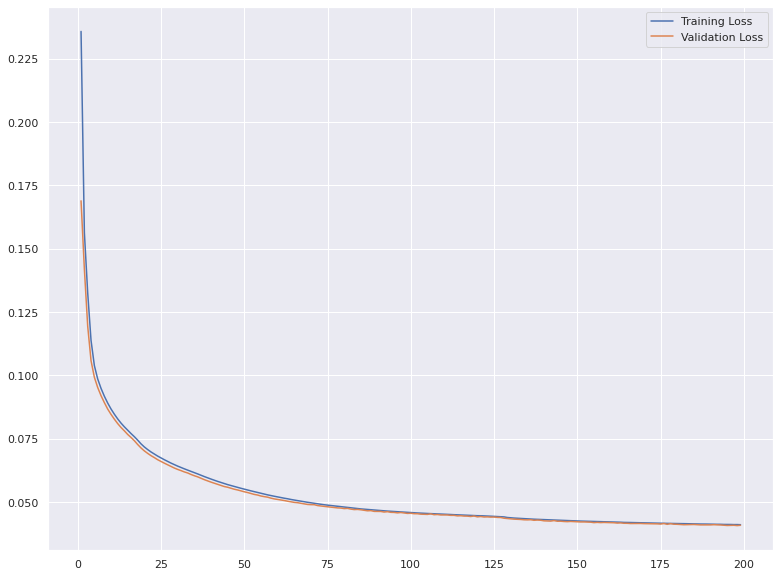

In [177]:
Plotting.plot_train(losses,val_loss,start=0,last=-1)

# For inference only

In [30]:
model = torch.jit.load("PR_Net_2505.pth")
model.to(device)
with torch.no_grad():
    d = test_dataset[:]

    inputs = d[:,1:input_num+1]
    targets = d[:,input_num+1:input_num+5]
    predictions = model(inputs)

    inputs, predictions, targets = inputs.to('cpu').numpy(), predictions.to('cpu').numpy(), targets.to('cpu').numpy()

In [31]:
predictions_orig= predictions* sds[input_num:input_num+4].reshape(1, -1) + means[input_num:input_num+4].reshape(1, -1)
targets_orig= targets * sds[input_num:input_num+4].reshape(1, -1) + means[input_num:input_num+4].reshape(1, -1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

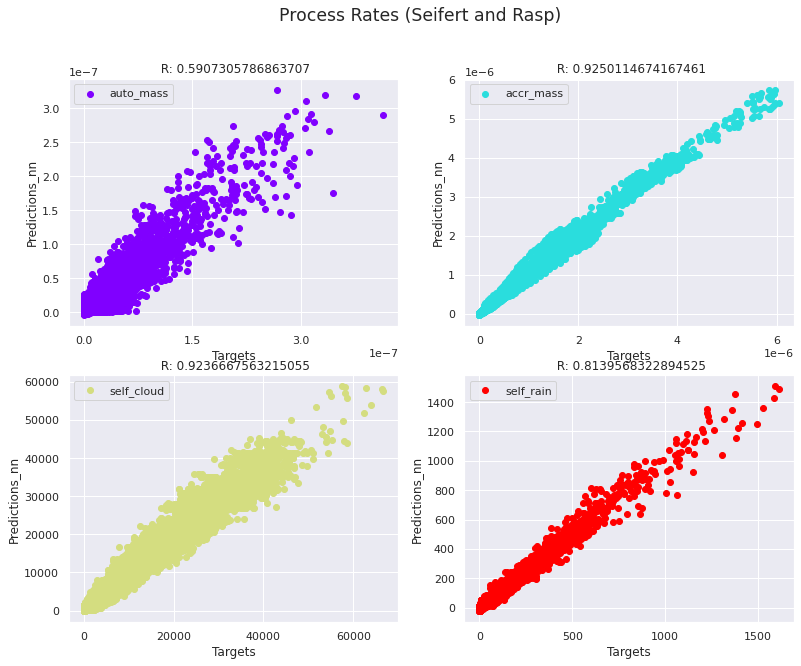

In [32]:
sns.set_theme(style="darkgrid")
Plotting.plot_predictions(targets_orig,predictions_orig,2,2,['auto_mass','accr_mass','self_cloud','self_rain'],"Process Rates (Seifert and Rasp)")

In [23]:
d= (d[:,1:].to('cpu').numpy()* sds[:].reshape(1, -1)) + means[:].reshape(1, -1)
moments=d[:,input_num+4:input_num+8]
meta_data=d[:,input_num+8:]

In [24]:
def EulerODE(auto,accr,sc_c,sc_r,moments,i):
    #Default setting as used in Seifert and Rasp. 5 second interval
    dt=5
    Lc=moments[0]
    Nc=moments[1]
    Lr=moments[2]
    Nr=moments[3]
    autoN = 1.0/xstar*auto
    accrN = accr/Xc3d[i]
    for i in range (8):
        Lc = Lc - auto*dt - accr*dt
        Lr = Lr + auto*dt + accr*dt
        Nc = Nc - accrN*dt - sc_c*dt
        Nr = Nr + autoN*dt - sc_r*dt
 
    return Lc,Nc,Lr,Nr
        
    

In [41]:

Xc3d = 4./3. * 3.14 * rhow * meta_data[:,0]**3
auto,accr,sc_c,sc_r=[predictions_orig[:,i] for i in range(4)]
moments_nn=[]
moments_true=[]
time=d[:,0]
for i in range (len(time)-1):
    if time[i]<time[i+1]:
        moments_true.append(moments[i+1,:]) #Because I have them with the data
        x=EulerODE(auto[i],accr[i],sc_c[i],sc_r[i],moments[i,:],i)
        moments_nn.append(x)

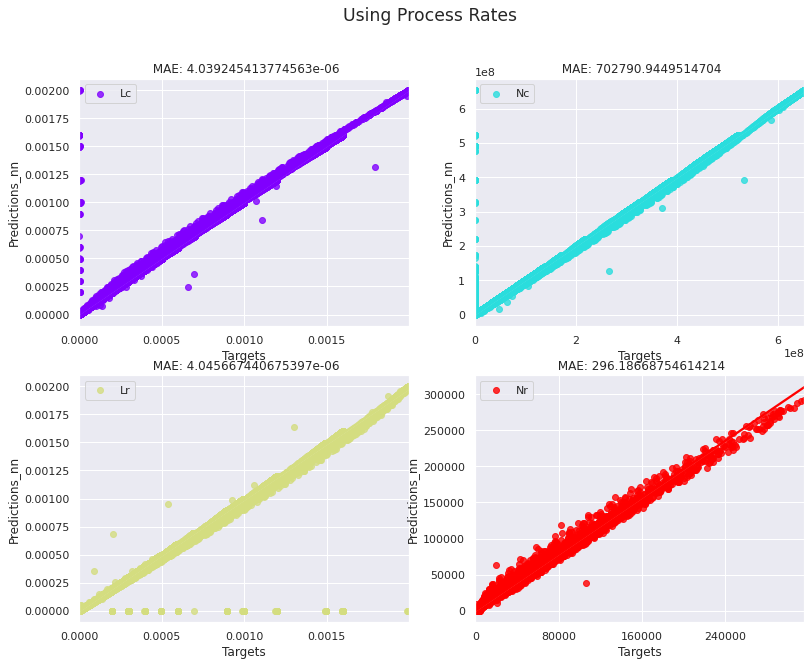

In [34]:
Plotting.plot_predictions_mm(np.asarray(moments_nn),np.asarray(moments_true),2,2,['Lc','Nc','Lr','Nr'],'Using Process Rates')

In [181]:
d = test_dataset[:]
inputs = d[2,1:input_num+1]
with torch.no_grad():
    print(model(inputs))
    traced_cell = torch.jit.trace(model, (inputs))
torch.jit.save(traced_cell, "PR_Net_2505.pth")

tensor([-0.1673, -0.2374, -0.2925, -0.1654], device='cuda:0')
